This example shows how to interpret anomalies in *tabular* data. 

To verify the effectiveness of DeepAID, we use a synthetic dataset here.

# Generate a synthetic dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
X.shape: (5050, 100)
perturb index: [25, 30, 40, 42, 47, 51, 58, 75, 78, 84]


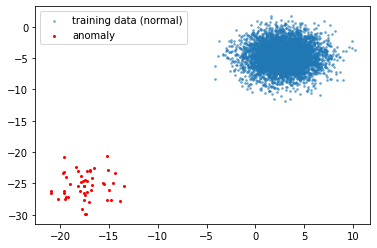

In [11]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import random 
import numpy as np

# Generate Gaussian blobs (single cluster) consists 5050 100-dimension samples
X, _ = make_blobs(n_samples=5050, centers=1, n_features=100,
                  random_state=0, cluster_std=2.)
print('X.shape:',X.shape)

# first 5000 samples are used for training
X_train = X[:-50,:]

# generate anomalies by randomly perturbing 10 dimensions (1%) in the last 50 samples
random.seed(0)
noise_idx = random.choices(list(range(100)),k=10)
noise_idx.sort()
print('perturb index:',noise_idx)
noise_data = np.random.uniform(-20,-20,(50,10))
X_anomaly = X[-50:,:]
X_anomaly[:,noise_idx] += noise_data

# visualize anomaly and normal training data in 2D space 
X_train_plot = X_train[:, noise_idx]
pca = PCA(n_components=2).fit(X_train_plot)
plt.scatter(X_train_plot[:, 0], X_train_plot[:, 1], alpha=0.5, s=3, label="training data (normal)")
X_anomaly_plot = X_anomaly[:,noise_idx]
pca = PCA(n_components=2).fit(X_anomaly_plot)
plt.scatter(X_anomaly_plot[:, 0], X_anomaly_plot[:, 1], alpha=1., s=4, c="r", label="anomaly")
plt.legend()
plt.show()

# Prepare a DL model for anomaly detection

In [12]:
# Train an autoencoder-based DL model
import numpy as np
import torch
import sys
sys.path.append('/Users/zhanghangsheng/others_code/HanDQ/DeepAID/deepaid')
from autoencoder import train, test, test_plot
from utils import validate_by_rmse, Normalizer
normer = Normalizer(X_train.shape[-1],online_minmax=False)
X_train = normer.fit_transform(X_train)
model, thres = train(X_train, X_train.shape[-1])
torch.save({'net':model,'thres':thres},'/Users/zhanghangsheng/others_code/HanDQ/DeepAID/demos/tabular_synthesis/save/autoencoder.pth.tar')

epoch:0/0 |Loss: 0.2599683105945587
epoch:0/10 |Loss: 0.20870228111743927
epoch:0/20 |Loss: 0.12251878529787064
epoch:0/30 |Loss: 0.0518486350774765
epoch:1/0 |Loss: 0.02416771836578846
epoch:1/10 |Loss: 0.020561272278428078
epoch:1/20 |Loss: 0.019190704450011253
epoch:1/30 |Loss: 0.019059639424085617
epoch:2/0 |Loss: 0.018613087013363838
epoch:2/10 |Loss: 0.018764011561870575
epoch:2/20 |Loss: 0.018767589703202248
epoch:2/30 |Loss: 0.018780352547764778
epoch:3/0 |Loss: 0.01864083856344223
epoch:3/10 |Loss: 0.018763311207294464
epoch:3/20 |Loss: 0.019030723720788956
epoch:3/30 |Loss: 0.019144006073474884
epoch:4/0 |Loss: 0.01867908425629139
epoch:4/10 |Loss: 0.019070617854595184
epoch:4/20 |Loss: 0.018971407786011696
epoch:4/30 |Loss: 0.019057834520936012
max AD score 0.16973726
thres: 0.16973726


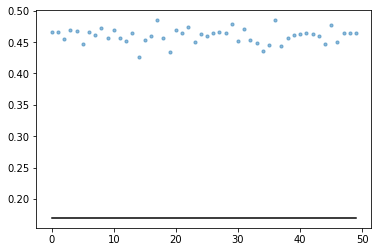

In [13]:
# Validate the performance of trained model
X_anomaly_norm = normer.transform(X_anomaly)
rmse_vec = test(model,thres,X_anomaly_norm)
test_plot(X_anomaly_norm, rmse_vec, thres) # ACC = 100%

# Interpret the generated anomalies

In [25]:
"""Load the model"""
from autoencoder import autoencoder
from utils import Normalizer
model_dict = torch.load('/Users/zhanghangsheng/others_code/HanDQ/DeepAID/demos/tabular_synthesis/save/autoencoder.pth.tar')
model = model_dict['net']
thres = model_dict['thres']


""" Create a DeepAID Tabular Interpreter"""
import sys
sys.path.append('/Users/zhanghangsheng/others_code/HanDQ/DeepAID/deepaid')
from tabular import TabularAID
my_interpreter = TabularAID(model,thres,input_size=100,k=10,steps=100,auto_params=False)

"""Interpret the anomalies"""
# for anomaly in X_anomaly:
anomaly = X_anomaly[5]
interpretation = my_interpreter(anomaly)
my_interpreter.show_table(anomaly,interpretation, normer) 

print('perturb index:',noise_idx)


ModuleNotFoundError: No module named 'tabular'

**As we can see that, the Interpreter successfully finds all perturbed dimensions**